#### Predection PAs
<small> looking at the three prior seasons

In [41]:
# packages and file import
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# wd
os.chdir('C:/Users/dalto/OneDrive/Pictures/Documents/Projects/MLB Season Model/')

In [42]:
pa_data = pd.read_csv('./data/cleaned/pa_injury_data.csv')
pa_data = pa_data.drop(columns=['Unnamed: 0'])

#### Change to Three Year Format

In [43]:
pa_data_3 = pa_data[pa_data['Season'] < 2024]

In [44]:
# List to collect results
combined_rows = []

# Numeric columns to sum/average (excluding Name and Season)
numeric_cols = pa_data_3.select_dtypes(include=[np.number]).columns.tolist()

for name, group in pa_data_3.groupby('Name'):
    group_sorted = group.sort_values('Season')
    # Only process if at least 3 seasons exist
    if len(group_sorted) < 3:
        continue
    for i in range(len(group_sorted) - 2):
        row1 = group_sorted.iloc[i]
        row2 = group_sorted.iloc[i + 1]
        row3 = group_sorted.iloc[i + 2]
        if row1['Name'] == row2['Name'] == row3['Name']:
            # New season label (use the latest season)
            season_label = int(row1['Season'])
            # Sum and average numeric columns
            summed = row1[numeric_cols] + row2[numeric_cols] + row3[numeric_cols]
            averaged = summed / 3
            # Build new row
            new_row = {'Name': name, 'Season': season_label}
            for col in numeric_cols:
                new_row[col] = averaged[col]
            combined_rows.append(new_row)

# Create DataFrame
pa_data_3 = pd.DataFrame(combined_rows)
pa_data_3 = pa_data_3[pa_data_3['Name'] != 'carlos perez'] # his name wasnt working for some reason
pa_data_3['Season'] = 2023
pa_data_3['Age'] = pa_data_3['Age'] + 1 # bc avg is bringing it down
pa_data_3.head()

,Name,Season,PA,Age,Days_Missed_Season
0,aaron hicks,2023,297.000000,33.0,60.333333
1,aaron judge,2023,595.666667,31.0,25.333333
2,abraham almonte,2023,76.000000,34.0,0.000000
3,abraham toro,2023,249.333333,26.0,3.333333
4,adam duvall,2023,407.666667,34.0,44.666667


In [45]:
pa_data_24 = pa_data[pa_data['Season'] == 2024]
pa_data_combined = pd.concat([pa_data_3, pa_data_24], ignore_index=True)

#### Normalize

In [46]:
def mean_year(group):
        avg = np.average(group, weights=group.index.map(lambda x: pa_data_combined.loc[x, 'PA']))
        return avg

In [47]:
def calculate_weighted_std(group):
    avg = np.average(group, weights=group.index.map(lambda x: pa_data_combined.loc[x, 'PA']))
    variance = np.average((group - avg)**2, weights=group.index.map(lambda x: pa_data_combined.loc[x, 'PA']))
    return np.sqrt(variance)

In [48]:
def z_scores(player_df, mean_df, std_df):
    # z scores for each stat and player, also creating a new df flow, add back names based on MLBAMID later
    z_scores = pd.DataFrame(index=player_df.index, columns=player_df.select_dtypes(include=[np.number]).columns)

    # scaled for each col
    for col in player_df.select_dtypes(include=[np.number]).columns:
        if col not in ['Season', 'MLBAMID']:  # not needed
            for idx in player_df.index:
                season = player_df.loc[idx, 'Season']
                value = player_df.loc[idx, col]
                mean = mean_df.loc[mean_df['Season'] == season, col].iloc[0]
                std = std_df.loc[std_df['Season'] == season, col].iloc[0]
                # scale so that 10 is 1 std away
                z_scores.loc[idx, col] = 100 + ((value - mean) / std * 10)

    z_scores['Season'] = player_df['Season']
    
    # cols to numeric
    for col in z_scores.columns:
        if col not in ['Season', 'MLBAMID']:
            z_scores[col] = pd.to_numeric(z_scores[col])
    
    # reinsert player names
    z_scores.insert(0, 'Name', player_df['Name']) 

    return z_scores

mean

In [49]:
# df to store mean results
mean_values = pd.DataFrame(index=pa_data_combined['Season'].unique())

for col in pa_data_combined.select_dtypes(include=[np.number]).columns:
    if col != 'Season' and col != 'MLBAMID':  # skip meaningless numeric
        yearly_mean = pa_data_combined.groupby('Season')[col].apply(mean_year)
        mean_values[col] = yearly_mean

# reset and rename index
mean_values = mean_values.reset_index()
mean_values = mean_values.rename(columns={'index': 'Season'})

# sort and display
mean_values = mean_values.sort_values(by=['Season'])
mean_values.head()

,Season,PA,Age,Days_Missed_Season
0,2023,444.096594,29.649429,20.531429
1,2024,448.020185,27.943522,14.225845


std

In [50]:
# Create empty DataFrame to store results
std_values = pd.DataFrame(index=pa_data_combined['Season'].unique())

# Loop through numeric columns
for col in pa_data_combined.select_dtypes(include=[np.number]).columns:
    if col != 'Season' and col != 'MLBAMID':  # skip meaningless numeric
        yearly_std = pa_data_combined.groupby('Season')[col].apply(calculate_weighted_std)
        std_values[col] = yearly_std

std_values = std_values.reset_index()
std_values = std_values.rename(columns={'index': 'Season'})

std_values = std_values.sort_values(by=['Season'])
std_values.head()

,Season,PA,Age,Days_Missed_Season
0,2023,154.560587,3.342656,20.899646
1,2024,180.852846,3.629216,25.591939


zscore

In [51]:
df_zscore = z_scores(pa_data_combined, mean_df=mean_values, std_df=std_values)
df_zscore.head()

,Name,Season,PA,Age,Days_Missed_Season
0,aaron hicks,2023,90.482917,110.023679,119.044296
1,aaron judge,2023,109.806515,104.040413,102.297601
2,abraham almonte,2023,76.184317,113.015311,90.176183
3,abraham toro,2023,87.398905,89.082248,91.771107
4,adam duvall,2023,97.643000,113.015311,111.548157


#### xgboost model

In [52]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

get next year PA

In [53]:
for idx in df_zscore.index:
    # retrive name, season
    name = df_zscore.loc[idx, 'Name']
    season = df_zscore.loc[idx, 'Season']
    # full df
    next_year = pa_data[(pa_data['Name'] == name) & (pa_data['Season'] == season + 1)]
    # add to df
    if not next_year.empty:
        df_zscore.loc[idx, 'next_pa'] = next_year['PA'].iloc[0] # need for later anaylsis

df_zscore_train = df_zscore.dropna(subset=['next_pa'])

#### model training loop

In [54]:
X = df_zscore_train.drop(columns=['Name', 'Season', 'next_pa'])
y = df_zscore_train['next_pa']

In [55]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2)

In [56]:
model = xgb.XGBRegressor(n_estimators = 100, random_state = 26)
model.fit(train_x, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=26, ...)

##### hyperparameter search

random search

In [57]:
from sklearn.model_selection import RandomizedSearchCV

In [58]:
rnd_search_params = {
    'learning_rate': np.linspace(0.05, 0.2, 4),          
    'max_leaves': np.linspace(1, 40, 20, dtype=int),     
    'min_child_weight': np.linspace(1, 20, 10),         
    'subsample': np.linspace(0.3, 0.9, 7),               
    'colsample_bytree': np.linspace(0.4, 1, 7),          
    'early_stopping_rounds': np.linspace(10, 100, 10, dtype=int),  
    'max_depth': np.linspace(0, 40, 20, dtype=int)       
}

rnd_searcher = RandomizedSearchCV(model, rnd_search_params, random_state=26, n_iter=1000, cv=5, n_jobs=-1, verbose=4)
rnd_searcher.fit(train_x, train_y, eval_set=[(test_x, test_y)])
print(rnd_searcher.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


KeyboardInterrupt: 

grid search

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
grid_search_params = {
    'learning_rate': [0.1, 0.15],   
    'max_leaves': [10, 11, 12],
    'min_child_weight': [17, 18, 19],      
    'subsample': [0.45, 0.5, 0.55],           
    'colsample_bytree':[0.8, 0.9, 1],     
    'early_stopping_rounds':[30, 40, 50],
    'max_depth': [2, 3, 4]
}
grid_searcher = GridSearchCV(model, grid_search_params, cv=5, n_jobs=-1, verbose=4)
grid_searcher.fit(train_x, train_y, eval_set=[(test_x, test_y)])
print(grid_searcher.best_params_)

Fitting 5 folds for each of 1458 candidates, totalling 7290 fits
[0]	validation_0-rmse:10.10173
[1]	validation_0-rmse:9.95633
[2]	validation_0-rmse:9.92221
[3]	validation_0-rmse:9.87552
[4]	validation_0-rmse:9.82120
[5]	validation_0-rmse:9.75860
[6]	validation_0-rmse:9.74848
[7]	validation_0-rmse:9.65598
[8]	validation_0-rmse:9.56320
[9]	validation_0-rmse:9.51945
[10]	validation_0-rmse:9.48473
[11]	validation_0-rmse:9.46895
[12]	validation_0-rmse:9.43942
[13]	validation_0-rmse:9.44393
[14]	validation_0-rmse:9.45946
[15]	validation_0-rmse:9.48480
[16]	validation_0-rmse:9.40626
[17]	validation_0-rmse:9.32923
[18]	validation_0-rmse:9.33647
[19]	validation_0-rmse:9.34183
[20]	validation_0-rmse:9.36188
[21]	validation_0-rmse:9.41052
[22]	validation_0-rmse:9.40377
[23]	validation_0-rmse:9.39613
[24]	validation_0-rmse:9.39234
[25]	validation_0-rmse:9.41144
[26]	validation_0-rmse:9.38539
[27]	validation_0-rmse:9.47325
[28]	validation_0-rmse:9.41554
[29]	validation_0-rmse:9.45614
[30]	validatio

In [59]:
opti_para = {'colsample_bytree': 1, 'early_stopping_rounds': 30, 'learning_rate': 0.1, 'max_depth': 2, 'max_leaves': 10, 'min_child_weight': 18, 'subsample': 0.5}
model.set_params(**opti_para)
model.fit(train_x, train_y, eval_set=[(test_x, test_y)])

[0]	validation_0-rmse:187.12076
[1]	validation_0-rmse:179.20045
[2]	validation_0-rmse:174.67198
[3]	validation_0-rmse:171.43593
[4]	validation_0-rmse:166.99559
[5]	validation_0-rmse:163.81393
[6]	validation_0-rmse:162.99280
[7]	validation_0-rmse:160.84042
[8]	validation_0-rmse:158.92526
[9]	validation_0-rmse:158.46234
[10]	validation_0-rmse:156.04073
[11]	validation_0-rmse:155.62683
[12]	validation_0-rmse:153.66141
[13]	validation_0-rmse:152.33733
[14]	validation_0-rmse:151.55969
[15]	validation_0-rmse:150.41404
[16]	validation_0-rmse:150.60060
[17]	validation_0-rmse:149.93882
[18]	validation_0-rmse:149.73111
[19]	validation_0-rmse:150.78881
[20]	validation_0-rmse:150.01800


[21]	validation_0-rmse:149.66434
[22]	validation_0-rmse:149.41950
[23]	validation_0-rmse:150.01695
[24]	validation_0-rmse:149.73102
[25]	validation_0-rmse:149.77277
[26]	validation_0-rmse:150.29598
[27]	validation_0-rmse:150.38873
[28]	validation_0-rmse:150.39401
[29]	validation_0-rmse:150.98328
[30]	validation_0-rmse:151.46379
[31]	validation_0-rmse:151.98514
[32]	validation_0-rmse:152.09750
[33]	validation_0-rmse:152.38977
[34]	validation_0-rmse:152.04040
[35]	validation_0-rmse:152.42861
[36]	validation_0-rmse:152.35011
[37]	validation_0-rmse:152.13011
[38]	validation_0-rmse:152.43754
[39]	validation_0-rmse:152.23846
[40]	validation_0-rmse:152.88033
[41]	validation_0-rmse:153.31785
[42]	validation_0-rmse:153.22627
[43]	validation_0-rmse:152.56474
[44]	validation_0-rmse:152.95036
[45]	validation_0-rmse:153.19372
[46]	validation_0-rmse:152.98322
[47]	validation_0-rmse:153.39334
[48]	validation_0-rmse:153.76067
[49]	validation_0-rmse:153.72483
[50]	validation_0-rmse:153.66528
[51]	valid

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=30, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
             max_leaves=10, min_child_weight=18, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, random_state=26, ...)

##### results

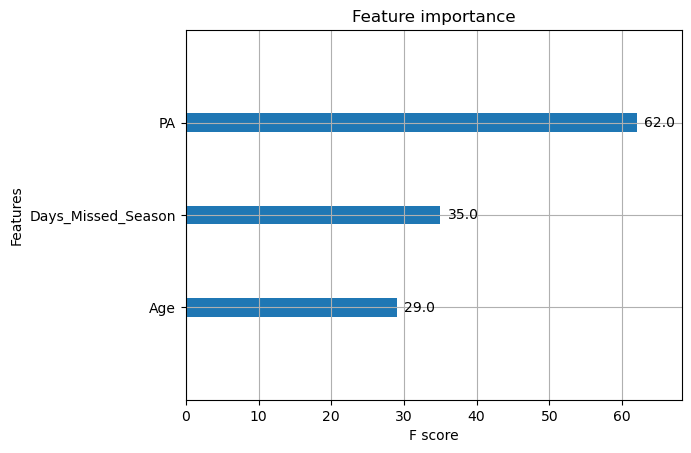

In [60]:
xgb.plot_importance(model)
plt.show()

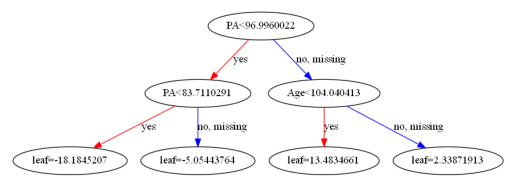

In [61]:
xgb.plot_tree(model, num_trees=3)
plt.show()

In [62]:
results = model.predict(test_x)
rmse = root_mean_squared_error(y_pred=results, y_true=test_y)
print(rmse)

149.41949614264007


In [63]:
pred_2025 = df_zscore[df_zscore['Season'] == 2024]
x_predections = pred_2025.drop(columns=['Name', 'Season', 'next_pa'])
xgb_final_preds = model.predict(x_predections)

In [64]:
pred_2025['pred_pa'] = xgb_final_preds
pred_2025 = pred_2025.drop(columns=['next_pa'])
export_pred = pred_2025[['Name', 'pred_pa']]
export_pred = export_pred.reset_index()
export_pred = export_pred.drop(columns='index')
export_pred.to_csv('./data/2025_Predections/pa_25_3.csv')

C:\Users\dalto\AppData\Local\Temp\ipykernel_23704\3555004269.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_2025['pred_pa'] = xgb_final_preds
